# Personalized correlations PNP3

 *Wake up glucose vs diet the day before*

The idea is that wakeup glucose is not the same on different days for the same person. I want to understand if it is due to the dietal behavior the day before. Also I want to see if associations between the food in the previous day and the wakeup glucose are different for different people. PNP3 cohort is suitable for this purpose because each person had more than 100 days of CGM connections.

I have to start with computing the wakeup glucose for all the people and each day. The method is to use the time between 6 and 7 unless a person logged the food at this time. Also I have to filter out days and people who logged any food after midnight.

In [1]:
import pandas as pd
from LabData.DataLoaders.CGMLoader import CGMLoader
from LabData.DataLoaders.DietLoggingLoader import DietLoggingLoader
import datetime
%matplotlib inline
cgml = CGMLoader()
dll = DietLoggingLoader()

import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from statsmodels.stats.multitest import fdrcorrection

## Calculating wakeup glucose

This function will only suit for pnp3 because it involves adding adjusted glucose from a file outside LabData. 

In [2]:
def calculate_wakeup_glucose_pnp3(time_between = [5,7], study_ids=3):    

    """Calculates wakeup glucose in the interval given in time_between 
    depending on the breakfast time"""
    
    # Get the cgm df and combine it with adjusted glucose 
    cgmdf = cgml.get_data(study_ids=study_ids).df
    cgmdf = cgml._remove_first_day_of_connections(cgmdf)
    cgmdf = cgmdf.reset_index()
    cgmdf['hour'] = cgmdf.Date.dt.hour
    cgmdf = cgmdf.set_index('Date')
    cgmdf.index = cgmdf.index.tz_localize(None)
    adj_gluc = pd.read_json('/home/elming/Cache/adj_gl.json')
    adj_gluc['ConnectionID'] = adj_gluc['ConnectionID'].astype(str)
    adj_gluc['GlucoseTimestamp'] = pd.to_datetime(adj_gluc['GlucoseTimestamp'])
    adj_gluc = adj_gluc.rename(columns={'GlucoseTimestamp':'Date'})
    adj_gluc = adj_gluc.set_index(['ConnectionID', 'Date'])
    cgm_adj = pd.merge(cgmdf, adj_gluc['GlucoseAdj50N13_Mm'], on=['ConnectionID', 'Date'])
    cgm_adj = cgm_adj.rename(columns={'GlucoseAdj50N13_Mm':'GlucoseAdj'})

    #  Get the log df 
    log = dll.get_data(study_ids=study_ids).df
    logdf = dll.add_nutrients(log, ['energy_kcal'])
    logdf = dll.squeeze_log(logdf)
    logdf = logdf.reset_index()
    logdf['Day'] = logdf['Date'].dt.date
    
    # Filter out beverages with 0 kcal
    logdf = logdf[logdf['energy_kcal'] != 0]
    
    # Filter out days with first meals earlier than 6 am 
    
    firstmeals = pd.DataFrame(logdf.sort_values(['RegistrationCode', 'Day', 'Date']).
                              groupby(['RegistrationCode', 'Day'])['Date'].first().rename('breakfast_ts'))
    firstmeals = firstmeals[(firstmeals['breakfast_ts'].dt.time > datetime.time(6, 0, 0))]
    
    # Dtype handling. After groupby 'Day' is an object, but I need it to be datetime
    firstmeals = firstmeals.reset_index('Day')
    firstmeals['Day'] = pd.to_datetime(firstmeals['Day'])
    firstmeals = firstmeals.set_index('Day', append=True)
    cgm_adj['Day'] = cgm_adj.index.date
    cgm_adj = cgm_adj.set_index(['RegistrationCode', 'Day'])
    
    # Get cgm and firstmeals ts in one df
    cgm_fm = pd.merge(cgm_adj, firstmeals, on=['RegistrationCode', 'Day'])
    
    # Leave cgm timestamps between 5 and 7 only
    cgm_fm = cgm_fm[(cgm_fm['hour'] >= time_between[0]) & (cgm_fm['hour'] < time_between[1])]
    
    # If breakfast was between 6 and 7 then wakeup glucose is a mean value between 5 and 6, otherwise between 6 and 7
    cgm_fm = cgm_fm[((cgm_fm['hour'] == time_between[0]) & (cgm_fm['breakfast_ts'].dt.hour == time_between[0] + 1)) | 
                    ((cgm_fm['hour'] == time_between[0] + 1) & (cgm_fm['breakfast_ts'].dt.hour >= time_between[1]))]
    wakeup_glucose = pd.DataFrame(cgm_fm.reset_index().groupby(['RegistrationCode', 'Day', 'hour'])['GlucoseAdj'].mean().rename(
                                'wakeup_glucose'))
    wakeup_glucose = wakeup_glucose.reset_index('hour').drop(columns='hour')
    
    return wakeup_glucose

In [3]:
wakeup_glucose = calculate_wakeup_glucose_pnp3()

In [4]:
wakeup_glucose.shape

(24018, 1)

In [5]:
wakeup_glucose.head()

wakeup_glucose
RegistrationCode Day                       
111527           2017-11-08      103.071429
                 2017-11-10       98.071429
                 2017-11-11      101.321429
                 2017-11-12      107.071429
                 2017-11-13      106.071429

In [8]:
wakeup_glucose.loc[('992638', slice(None))]

,wakeup_glucose
Day,
2017-06-16,96.285714
2017-06-17,97.535714
2017-06-18,89.785714
2017-06-19,92.785714
2017-06-20,86.285714
...,...
2018-07-25,116.250000
2018-07-26,104.500000
2018-07-27,101.750000


## Wakeup glucose variability distribution

In [240]:
def q1(x):
    return x.quantile(0.25)

def q3(x):
    return x.quantile(0.75)

def interquartile_range(x):
    return q3(x) - q1(x)

f = {'wakeup_glucose': ['median', 'std', q1,q3, interquartile_range]}

In [241]:
morn_gluc_distr = wakeup_glucose.groupby('RegistrationCode').agg(f)

In [242]:
morn_gluc_distr.columns = morn_gluc_distr.columns.droplevel()

In [243]:
morn_gluc_distr.sample(10)

,median,std,q1,q3,interquartile_range
RegistrationCode,,,,,
948714,89.096154,8.266824,84.450000,94.321429,9.871429
525994,84.045455,7.749498,80.083333,88.692308,8.608974
168236,99.100000,7.714326,96.000000,104.785714,8.785714
331758,105.161111,13.665523,97.468750,114.826923,17.358173
147121,90.222222,8.729051,85.000000,94.714286,9.714286
848368,80.607143,7.999681,76.428571,86.200000,9.771429
903238,86.974747,9.747738,80.973214,93.500000,12.526786
433346,90.136752,8.578790,85.645833,96.132576,10.486742
12752,102.350000,18.322500,92.604167,111.187500,18.583333


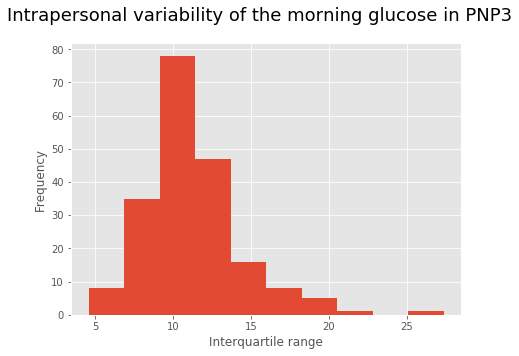

In [244]:
fig = plt.figure(figsize=(7,5))
fig.suptitle('Intrapersonal variability of the morning glucose in PNP3', fontsize=18)
ax1 = fig.add_subplot(111)
ax1.set_xlabel('Interquartile range')
morn_gluc_distr['interquartile_range'].plot.hist()

In [245]:
morn_gluc_distr['interquartile_range'].mean()

11.246914242235173

In [246]:
morn_gluc_distr['median'].mean()

95.1138406610118

In [247]:
morn_gluc_distr['%iqr_median'] = morn_gluc_distr['interquartile_range'] / morn_gluc_distr['median']

In [248]:
morn_gluc_distr[morn_gluc_distr['q3']<100].shape

(103, 6)

In [249]:
wakeup_glucose.shape

(24018, 1)

For how many days did people wear CGM sensor?

In [250]:
wakeup_glucose

wakeup_glucose
RegistrationCode Day                       
111527           2017-11-08      103.071429
                 2017-11-10       98.071429
                 2017-11-11      101.321429
                 2017-11-12      107.071429
                 2017-11-13      106.071429
...                                     ...
997735           2019-07-19      104.714286
                 2019-07-20      108.464286
                 2019-07-21      107.214286
                 2019-11-02      108.714286
                 2019-11-03      101.714286

[24018 rows x 1 columns]

In [251]:
count = wakeup_glucose.reset_index().groupby('RegistrationCode')['Day'].count()

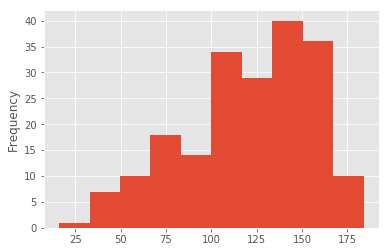

In [252]:
count.plot.hist()

Let's take all people with at least 50 days of  connections.

In [253]:
rc_to_keep = count[count >= 100].index

In [170]:
len(rc_to_keep)

191

We have 192 people in total.

## Leave only those people with more than 50 days of connections

In [6]:
def more_than_x_connection_days(wakeup_glucose_df, x=50):
    wakeup_glucose_df = wakeup_glucose_df.reset_index()
    count = wakeup_glucose_df.groupby('RegistrationCode')['Day'].count()
    rc_to_keep = count[count >= x].index
    # wakeup_glucose = wakeup_glucose.set_index('RegistrationCode').loc[rc_to_keep]
    wakeup_glucose_df = wakeup_glucose_df[wakeup_glucose_df['RegistrationCode'].isin(rc_to_keep)]
    return wakeup_glucose_df

In [7]:
wakeup_glucose = more_than_x_connection_days(wakeup_glucose, x=50)

In [11]:
wakeup_glucose.head()

,RegistrationCode,Day,wakeup_glucose
0,111527,2017-11-08,103.071429
1,111527,2017-11-10,98.071429
2,111527,2017-11-11,101.321429
3,111527,2017-11-12,107.071429
4,111527,2017-11-13,106.071429


In [8]:
wakeup_glucose.shape

(23706, 3)

## Dietary features from the day before

In [9]:
def prepare_diet_data(wg_df, nutrient_list, study_ids, min_cal_per_day=1000, how='total_diet', daysplithours=[6,12,17,21]):
    
    """Prepare joint df with wg and dietary features from the day before.
    One can choose to correlate with total diet from the perevious day or with diet split into breakfast, lunch and dinner.
    :param wg_df : wakeup_glucose DataFrame
    :param nutrient_list: list of nutrients to select (for the full list see LabData/DataLoaders/Lists/meal_features.txt)
                                e.g. ['energy_kcal', 'carbohydrate_g', 'protein_g', 'totallipid_g']
                                if None, all nutrients are selected
    :param min_cal_per_day:
    :param how: string, can be 'total_diet' or 'split_diet'. If split_diet is passed, then the day will be split into breakfast,
                        lunch and dinner and the nutrients will be calculated accordingly.
    :param daysplithours: list telling how to split the day 
        
    :return data_df with wg and dietary features to perform the correlations with
    """ 
    carbs_cal_per_gram = 4
    fat_cal_per_gram = 9
    prot_cal_per_gram = 4
    
    log = dll.get_data(study_ids=study_ids).df
    logdf = dll.add_nutrients(log, nutrient_list)
    logdf = dll.squeeze_log(logdf)
    logdf = logdf.reset_index()
    logdf['Day'] = logdf['Date'].dt.date
    #Identify days with good log more than min_cal_per_day
    totaldaylog = logdf.drop(columns=['meal_type','score']).groupby(['RegistrationCode', 'Day']).sum()
    totaldaylog = totaldaylog[totaldaylog['energy_kcal'] >= min_cal_per_day]
    days_to_keep = totaldaylog.index
    logdf = logdf.set_index(['RegistrationCode', 'Day'])
    logdf = logdf.loc[days_to_keep]
    
    if how == 'total_diet':
        # Add derived  features
        totaldaylog['carbs/lipids'] = totaldaylog['carbohydrate_g'] / totaldaylog['totallipid_g']
        totaldaylog['caloric%carbs'] = totaldaylog['carbohydrate_g'] * carbs_cal_per_gram / totaldaylog['energy_kcal']
        totaldaylog['caloric%fat'] = totaldaylog['totallipid_g'] * fat_cal_per_gram / totaldaylog['energy_kcal']
        # Change dtype to datetime for merge with wg_df
        totaldaylog = totaldaylog.reset_index('Day')
        totaldaylog['Day'] = pd.to_datetime(totaldaylog['Day'])
        # Add day to the current day for merge with correct wg
        totaldaylog['Day'] = totaldaylog['Day'] + datetime.timedelta(days=1)
        diet_data = totaldaylog.set_index('Day', append=True)
        
    elif how == 'split_diet':
        logdf['alloc'] = ''
        # Breakfast
        logdf.loc[(logdf['Date'].dt.time >= datetime.time(daysplithours[0], 0, 0)) & 
              (logdf['Date'].dt.time < datetime.time(daysplithours[1], 0, 0)),'alloc'] = 'b'
        # Lunch
        logdf.loc[(logdf['Date'].dt.time >= datetime.time(daysplithours[1], 0, 0)) & 
              (logdf['Date'].dt.time < datetime.time(daysplithours[2], 0, 0)),'alloc'] = 'l'
        # Dinner
        logdf.loc[(logdf['Date'].dt.time >= datetime.time(daysplithours[2], 0, 0)) & 
              (logdf['Date'].dt.time < datetime.time(daysplithours[3], 0, 0)),'alloc'] = 'd'
        # Late dinner 
        logdf.loc[(logdf['Date'].dt.time > datetime.time(daysplithours[3], 0, 0)),'alloc'] = 'ld'
        
        logdf = logdf.drop(columns='score')
        
        # We are only interested in  food between 6 and 24. Days where people logged food during the night will be out after merge with wg_df
        logdf = logdf[logdf['alloc'] != '']
        splitlog = logdf.reset_index().groupby(['RegistrationCode', 'Day', 'alloc']).sum()
        splitlog = splitlog.unstack(level=-1)
        splitlog.columns = ['_'.join(splitlog.columns[i]) for i in range(len(splitlog.columns))]
        # Add carbs/lipids ration
        splitlog['carbs/lipids_b'] = splitlog['carbohydrate_g_b'] / splitlog['totallipid_g_b']
        splitlog['carbs/lipids_d'] = splitlog['carbohydrate_g_d'] / splitlog['totallipid_g_d']
        splitlog['carbs/lipids_l'] = splitlog['carbohydrate_g_l'] / splitlog['totallipid_g_l']

        splitlog = splitlog.reset_index('Day')
        splitlog['Day'] = pd.to_datetime(splitlog['Day'])
        # Add day to the current day for merge with correct wg
        splitlog['Day'] = splitlog['Day'] + datetime.timedelta(days=1)
        diet_data = splitlog.fillna(0).set_index('Day', append=True)
        
    
    return diet_data

Dietary features to test the correlations on:
'alcohol_g', 'caffeine_mg', 'carbohydrate_g', 'carbs/fat', 'energy_kcal', 'protein_g', 'sodium_mg', 'sugarstotal_g', 'totaldietaryfiber_g', 'totallipid_g'

In [10]:
nutrient_list = ['caffeine_mg', 'carbohydrate_g', 'energy_kcal', 'protein_g', 'sodium_mg', 'sugarstotal_g', 'totaldietaryfiber_g', 'totallipid_g']

total_diet = prepare_diet_data(wakeup_glucose, nutrient_list, study_ids=3, min_cal_per_day=1000, how='total_diet')

split_diet = prepare_diet_data(wakeup_glucose, nutrient_list, study_ids=3, min_cal_per_day=1000, how='split_diet')

In [11]:
total_diet.head()

energy_kcal  protein_g  totaldietaryfiber_g  \
RegistrationCode Day                                                       
111527           2017-10-07  1628.551492  73.908813            11.494648   
                 2017-10-08  1170.992650  40.689566             4.879275   
                 2017-10-09  1169.040000  51.124900             8.873000   
                 2017-11-06  1672.065725  57.076296            10.300168   
                 2017-11-07  1146.560500  34.195410             8.200050   

                                  weight    sodium_mg  totallipid_g  \
RegistrationCode Day                                                  
111527           2017-10-07  5110.200001  3522.806605     79.195531   
                 2017-10-08  4540.500000  1823.482200     68.169205   
                 2017-10-09  3056.000000   875.554000     53.919700   
                 2017-11-06  1620.630000  2046.856887     90.674065   
                 2017-11-07  1865.140000  1454.499167     36.157640   

                             sugarstotal_g  caffeine_mg  carbohydrate_g  \
RegistrationCode Day                                                      
111527           2017-10-07       2.637400        383.4      149.287278   
                 2017-10-08       8.276208        365.5       97.676125   
                 2017-10-09       1.964900        328.5      116.313900   
                 2017-11-06       7.224420        265.8      156.910187   
                 2017-11-07      36.356777        488.4      169.203500   

                             carbs/lipids  caloric%carbs  caloric%fat  
RegistrationCode Day                                                   
111527           2017-10-07      1.885047       0.366675     0.437665  
                 2017-10-08      1.432848       0.333652     0.523934  
                 2017-10-09      2.157169       0.397981     0.415108  
                 2017-11-06      1.730486       0.375368     0.488059  
                 2017-11-07      4.679606       0.590299     0.283822

In [12]:
total_diet = pd.merge(total_diet, wakeup_glucose, on=['RegistrationCode', 'Day'])

In [13]:
split_diet = pd.merge(split_diet, wakeup_glucose, on=['RegistrationCode', 'Day'])

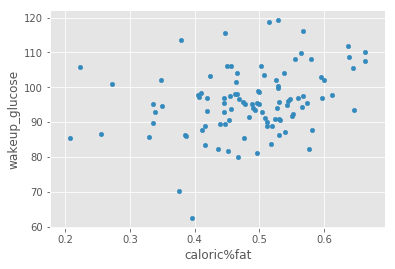

In [14]:
total_diet.set_index('RegistrationCode').loc['372475'].plot.scatter(x='caloric%fat', y='wakeup_glucose')
# plt.title('RC91050 spearman rho = 0.47')

In [19]:
total_diet[total_diet['RegistrationCode'] == '831208']

,RegistrationCode,Day,protein_g,sugarstotal_g,caffeine_mg,energy_kcal,sodium_mg,totaldietaryfiber_g,carbohydrate_g,weight,totallipid_g,carbs/lipids,caloric%carbs,caloric%fat,wakeup_glucose
14300,831208,2018-10-12,87.614256,13.366487,202.5,1986.034451,4256.532750,30.800896,156.095255,2155.0,114.938039,1.358082,0.314386,0.520858,97.928571
14301,831208,2018-10-13,142.478988,12.839800,225.0,2128.314210,3617.774600,30.881035,187.463605,2398.0,92.005907,2.037517,0.352323,0.389065,98.178571
14302,831208,2018-10-16,147.082305,14.231562,112.5,2588.074462,4049.378280,35.053491,206.571283,2465.0,132.390359,1.560320,0.319266,0.460386,100.178571
14303,831208,2018-10-17,130.661294,40.438301,202.5,2312.795830,4479.469120,45.404857,197.905565,2828.0,108.899595,1.817321,0.342279,0.423771,99.428571
14304,831208,2018-10-20,135.339004,33.802343,225.0,2923.167362,4444.044300,40.753847,212.128786,2497.0,168.170823,1.261389,0.290273,0.517773,92.928571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14423,831208,2019-04-22,152.597170,24.165842,225.0,2541.715600,6540.289500,40.582801,274.969160,2694.0,95.472330,2.880093,0.432730,0.338059,88.500000
14424,831208,2019-04-23,193.292499,37.676970,225.0,2401.259100,4761.727400,36.532650,192.285279,2526.0,86.859930,2.213740,0.320307,0.325554,95.500000
14425,831208,2019-04-26,109.078619,20.859102,90.0,1887.756100,3383.635000,23.658670,128.588430,1379.0,106.583510,1.206457,0.272468,0.508144,107.214286
14426,831208,2019-04-27,142.998320,8.871050,90.0,1788.391000,2348.293200,11.006820,128.796100,1342.0,76.526076,1.683035,0.288071,0.385114,95.714286


In [24]:
total_diet.set_index(['RegistrationCode', 'Day']).shape

(21085, 13)

In [50]:
total_diet = total_diet.rename(columns={'sodium_mg':'sodium_mg_total', 'caffeine_mg':'caffeine_mg_total', 'weight':'food_weight_total',
                                'sugarstotal_g':'sugars_g_total', 'energy_kcal':'energy_kcal_total', 'carbohydrate_g':'carbohydrate_g_total', 
                                'totaldietaryfiber_g':'dietaryfiber_g_total', 'totallipid_g':'lipid_g_total', 'protein_g':'protein_g_total',
                                'carbs/lipids':'carbs/lipids_total', 'caloric%carbs':'caloric%carbs_total', 'caloric%fat':'caloric%fat_total'})

In [66]:
split_diet.columns

Index(['RegistrationCode', 'Day', 'energy_kcal_b', 'energy_kcal_d',
       'energy_kcal_l', 'energy_kcal_ld', 'protein_g_b', 'protein_g_d',
       'protein_g_l', 'protein_g_ld', 'dietaryfiber_g_b', 'dietaryfiber_g_d',
       'dietaryfiber_g_l', 'dietaryfiber_g_ld', 'food_weight_g_b',
       'food_weight_g_d', 'food_weight_g_l', 'food_weight_g_ld', 'sodium_mg_b',
       'sodium_mg_d', 'sodium_mg_l', 'sodium_mg_ld', 'lipid_g_b', 'lipid_g_d',
       'lipid_g_l', 'lipid_g_ld', 'sugars_g_b', 'sugars_g_d', 'sugars_g_l',
       'sugars_g_ld', 'caffeine_mg_b', 'caffeine_mg_d', 'caffeine_mg_l',
       'caffeine_mg_ld', 'carbohydrate_g_b', 'carbohydrate_g_d',
       'carbohydrate_g_l', 'carbohydrate_g_ld', 'carbs/lipids_b',
       'carbs/lipids_d', 'carbs/lipids_l', 'wakeup_glucose'],
      dtype='object')

In [65]:
split_diet = split_diet.rename(columns={'totaldietaryfiber_g_b':'dietaryfiber_g_b',
       'totaldietaryfiber_g_d':'dietaryfiber_g_d', 'totaldietaryfiber_g_l':'dietaryfiber_g_l',
       'totaldietaryfiber_g_ld':'dietaryfiber_g_ld', 'weight_b':'food_weight_g_b', 'weight_d':'food_weight_g_d', 'weight_l':'food_weight_g_l',
       'weight_ld':'food_weight_g_ld', 'totallipid_g_b':'lipid_g_b', 'totallipid_g_d':'lipid_g_d', 'totallipid_g_l':'lipid_g_l',
       'totallipid_g_ld':'lipid_g_ld', 'sugarstotal_g_b':'sugars_g_b', 'sugarstotal_g_d':'sugars_g_d',
       'sugarstotal_g_l':'sugars_g_l', 'sugarstotal_g_ld':'sugars_g_ld'})

In [51]:
total_diet.set_index(['RegistrationCode', 'Day']).corr(method='pearson').iloc[-1,:]

energy_kcal_total       0.031222
protein_g_total         0.060755
dietaryfiber_g_total   -0.010483
food_weight_total       0.004629
sodium_mg_total         0.030842
lipid_g_total           0.039025
sugars_g_total         -0.025737
caffeine_mg_total      -0.025286
carbohydrate_g_total   -0.015119
carbs/lipids_total     -0.042158
caloric%carbs_total    -0.031196
caloric%fat_total       0.014725
wakeup_glucose          1.000000
Name: wakeup_glucose, dtype: float64

## Correlation table

I could also do the same for the night CV. Make function calculate_night_stats(). 

In [15]:
def corr_wg_dietdaybefore(data_corr, method='spearman'):
    
    """Calculate correlations between the wakeup glucose (WG) and the diet the day before.
    :param method: String 'spearman' or 'pearson'
    
    """
    from scipy.stats import pearsonr, spearmanr
    from statsmodels.stats.multitest import fdrcorrection
    
    data_corr = data_corr.drop(columns='Day')
    means = data_corr.groupby('RegistrationCode').mean()
    std = data_corr.groupby('RegistrationCode').std()
    data_corr= data_corr.set_index('RegistrationCode')
    # standartization of the values into z scores
    for rc in data_corr.index.unique():
        data_corr.loc[rc] = (data_corr.loc[rc] - means.loc[rc])/std.loc[rc]
    data_corr = round(data_corr, 4)
    statistics_df = pd.DataFrame(means.stack(level=-1))
    # I don't want to calculate correlation between wg and itself
    #     slice_column_names = statistics_df.index.levels[-1][statistics_df.index.levels[-1] != 'wakeup_glucose']
    #     statistics_df = statistics_df.loc[(slice(None), slice_column_names), :]
    
    if method == 'spearman':
        
        statistics_df['rho'] = 0
        statistics_df['pvalue'] = 0
        statistics_df = statistics_df.drop(columns=0)

        for rc in data_corr.index.unique():

            for column in data_corr.columns:
                spearman = spearmanr(data_corr.loc[rc]['wakeup_glucose'], data_corr.loc[rc][column])
                statistics_df.loc[(rc, column), 'rho'] = spearman[0]
                statistics_df.loc[(rc, column), 'pvalue'] = spearman[1]
                
    elif method == 'pearson':

        statistics_df['rho'] = 0
        statistics_df['pvalue'] = 0
        statistics_df = statistics_df.drop(columns=0)

        for rc in data_corr.index.unique():
            for column in data_corr.drop(columns='wakeup_glucose').columns:
                pearson = pearsonr(data_corr.loc[rc]['wakeup_glucose'], data_corr.loc[rc][column])
                statistics_df.loc[(rc, column), 'rho'] = pearson[0]
                statistics_df.loc[(rc, column), 'pvalue'] = pearson[1]
    
    values = {'rho': 0, 'pvalue': 1}
    statistics_df = statistics_df.fillna(value=values)
    # Add FDR corrected pvalues
    pvalues = statistics_df['pvalue']
    pvalues_corrected = pd.Series(fdrcorrection(pvalues)[1])
    pvalues_corrected.index = statistics_df.index
    statistics_df['pvalue_corrected'] = pvalues_corrected
    
    return statistics_df
    

In [16]:
# total_diet = total_diet.drop(columns='index')
# split_diet = split_diet.drop(columns='index')

In [84]:
corr_table_total = corr_wg_dietdaybefore(total_diet, method='spearman')

In [71]:
corr_table_split = corr_wg_dietdaybefore(split_diet)

In [274]:
corr_table_split.isnull().sum()

rho                 0
pvalue              0
pvalue_corrected    0
dtype: int64

In [53]:
corr_table_total.columns

Index(['rho', 'pvalue', 'pvalue_corrected'], dtype='object')

In [68]:
corr_table_split.head()

rho    pvalue  pvalue_corrected
RegistrationCode                                                     
111527           energy_kcal_b  -0.168110  0.052182          0.393557
                 energy_kcal_d  -0.019390  0.824024          0.984227
                 energy_kcal_l  -0.042736  0.623925          0.927945
                 energy_kcal_ld  0.068506  0.431572          0.837097
                 protein_g_b    -0.056271  0.518412          0.887056

In [72]:
corr_table_split.index.get_level_values(0).nunique()

191

In [75]:
slice_column_names = corr_table_total.index.levels[-1][corr_table_total.index.levels[-1] != 'wakeup_glucose']
corr_table_total = corr_table_total.loc[(slice(None), slice_column_names), :]

In [73]:
slice_column_names = corr_table_split.index.levels[-1][corr_table_split.index.levels[-1] != 'wakeup_glucose']
corr_table_split = corr_table_split.loc[(slice(None), slice_column_names), :]

In [74]:
corr_table_split.shape

(7449, 3)

Normality testing method

In [ ]:
# from numpy.random import seed
# from numpy.random import randn
# from scipy.stats import shapiro
# # seed the random number generator
# seed(1)
# # normality test
# for column in data.columns:
#     stat, p = shapiro(data.loc['300747'][column])
#     print('Statistics=%.3f, p=%.3f' % (stat, p))
#     # interpret
#     alpha = 0.05
#     if p > alpha:
#         print(column, ': Sample looks Gaussian (fail to reject H0)')
#     else:
#         print(column, ': Sample does not look Gaussian (reject H0)')

In PNP3 patients probably avoided alcohol due to the diet. I should exclude this feature from the correlation analysis.

In [ ]:
# spearmancorr = data_corr_total.corr(method='spearman')
# spearmancorr

In [ ]:
# sb.heatmap(pearsoncorr, 
#             xticklabels=pearsoncorr.columns,
#             yticklabels=pearsoncorr.columns,
#             cmap='RdBu_r',
#             annot=True,
#             linewidth=0.5)

In [ ]:
# def calculate_pvalues(df):
#     df = df.dropna()._get_numeric_data()
#     dfcols = pd.DataFrame(columns=df.columns)
#     pvalues = dfcols.transpose().join(dfcols, how='outer')
#     for r in df.columns:
#         for c in df.columns:
#             pvalues[r][c] = round(spearmanr(df[r], df[c])[1], 4)
#     return pvalues

# calculate_pvalues(data.loc['111527']) 

In [292]:
corr_table_split[(corr_table_split['pvalue_corrected'] < 0.1)].sample(8)

,,rho,pvalue,pvalue_corrected
RegistrationCode,,,,
93282,weight_b,0.365412,6.396225e-05,0.002398
992638,energy_kcal_ld,0.259910,6.681474e-04,0.020633
91050,carbohydrate_g_l,0.480642,6.271221e-07,0.000025
963150,carbohydrate_g_b,0.254512,1.934786e-03,0.050136
93282,totallipid_g_b,0.289620,1.775102e-03,0.047020
91050,carbs/lipids_l,0.489817,3.544098e-07,0.000014
992638,carbohydrate_g_ld,0.261795,6.082759e-04,0.019182
158748,protein_g_d,0.272167,4.568279e-03,0.092925


In [197]:
corr_table_total[(corr_table_total['pvalue_corrected'] < 0.05)].shape

(117, 3)

In [198]:
corr_table_total[(corr_table_total['pvalue'] < 0.05)].shape

(362, 3)

In [199]:
corr_table_total.head()

rho    pvalue  pvalue_corrected
RegistrationCode                                                     
111527           totallipid_g   -0.190140  0.027770          0.150552
                 weight          0.046509  0.593602          0.817932
                 caffeine_mg     0.006985  0.936158          0.982690
                 sodium_mg       0.008531  0.922064          0.979249
                 carbohydrate_g  0.137657  0.112711          0.363455

## Visualize correlations

In [101]:
def plot_corr_heatmap(corr_table, sign_threshold=0.05, pvalue_column='pvalue_corrected', savefig=False, filename=None):
    """Handles the table with correlations and pvalues and draws a heatmap with significant coefficients"""
        
    import plotly.graph_objects as go
    # Unsignificant correlations replace with None for not having them in the graph
    corr_table['significant'] = 0
    corr_table.loc[(corr_table[pvalue_column] < sign_threshold),'significant'] = 1
    corr_table.loc[(corr_table['significant'] == 0), 'rho'] = None
    # Delete rows with wg correlations to itself
    slice_column_names = corr_table.index.levels[-1][corr_table.index.levels[-1] != 'wakeup_glucose']
    corr_table = corr_table.loc[(slice(None), slice_column_names), :]
    # Prepare data for visualization
    signif_corr = corr_table.unstack(level=-1)['rho']
    signif_corr.columns.name = None
    rc_list = signif_corr.index
    rc_list = ['RC' + item for item in rc_list]
    diet_feat_list = signif_corr.columns
    sign_corr_list = signif_corr.values.tolist()

    # Build the heatmap
    fig = go.Figure(data=go.Heatmap(
                       z=sign_corr_list,
                       x=diet_feat_list,
                       y=rc_list,
                        colorscale = 'Viridis',
                       hoverongaps = False))
    fig.update_layout(
        title={
            'text': "Personalized Spearman correlations between the wake-up glucose and dietary features from the day before",
            'y':0.95,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
        xaxis_title="Dietary features",
        yaxis_title="Participant RC"
        )
    fig.show()
    
    if savefig:
        path = '/home/elming/MA_Thesis/figures/' + filename + '.html'
        fig.write_html(path)


In [105]:
corr_df = corr_table_total.copy()

In [106]:
plot_corr_heatmap(corr_df, sign_threshold=0.05, pvalue_column='pvalue_corrected', savefig=True, filename='corr_total_diet_pnp3_fdr')

In [103]:
corr_df = corr_table_split.copy()

In [104]:
plot_corr_heatmap(corr_df, sign_threshold=0.05, pvalue_column='pvalue', savefig=True, filename='corr_split_diet_pnp3_nonfdr')

In [79]:
corr_table_total.head()

rho    pvalue  pvalue_corrected
RegistrationCode                                                           
111527           energy_kcal_total    -0.099590  0.252258          0.561331
                 protein_g_total      -0.002361  0.978401          0.992576
                 dietaryfiber_g_total  0.035470  0.684102          0.865601
                 food_weight_total     0.072414  0.405698          0.694722
                 sodium_mg_total       0.004213  0.961464          0.990378

In [82]:
count = corr_df[corr_df['significant'] == 1].groupby(['RegistrationCode', 'significant']).count()

In [83]:
count.nlargest(5,'pvalue_corrected')

,,rho,pvalue,pvalue_corrected
RegistrationCode,significant,,,
215130,1,7,7,7
451959,1,6,6,6
91050,1,6,6,6
448705,1,5,5,5
372475,1,4,4,4


In [44]:
tmp = corr_table_total.reset_index().set_index('RegistrationCode').loc['372475']
tmp = tmp.rename(columns={'level_1':'feature'})
# list(tmp[tmp['significant'] == 1]['feature'])
tmp[tmp['significant'] == 1]

,feature,rho,pvalue,pvalue_corrected,significant
RegistrationCode,,,,,
372475,sugarstotal_g,-0.388128,0.000061,0.000716,1
372475,carbohydrate_g,-0.375948,0.000107,0.001240,1
372475,carbs/lipids,-0.363228,0.000189,0.002104,1
372475,caloric%carbs,-0.375080,0.000111,0.001275,1
372475,caloric%fat,0.294596,0.002786,0.024304,1


In [302]:
count = corr_table_split[corr_table_split['significant'] == 1].groupby(['RegistrationCode', 'significant']).count()

In [303]:
count.nlargest(10,'pvalue_corrected')

,,rho,pvalue,pvalue_corrected
RegistrationCode,significant,,,
992638,1,9,9,9
859286,1,6,6,6
605764,1,5,5,5
704171,1,5,5,5
91050,1,5,5,5
93282,1,5,5,5
142162,1,4,4,4
215130,1,4,4,4
356171,1,4,4,4


In [122]:
corr_table_split[corr_table_split['significant'] == 1].head()

rho    pvalue  pvalue_corrected  \
RegistrationCode                                                        
12752            caffeine_mg_b   0.406316  0.000246          0.008541   
132178           carbs/lipids_l -0.315838  0.000109          0.003946   
142162           totallipid_g_l  0.323306  0.000768          0.023314   
                 sodium_mg_l     0.359560  0.000165          0.005873   
                 protein_g_l     0.389539  0.000040          0.001530   

                                 significant  
RegistrationCode                              
12752            caffeine_mg_b             1  
132178           carbs/lipids_l            1  
142162           totallipid_g_l            1  
                 sodium_mg_l               1  
                 protein_g_l               1

In [305]:
# I want to see which features are most often correlated with wg
tmp = corr_table_split[corr_table_split['significant'] == 1].reset_index(level=-1).rename(columns={'level_1':'feature'})
tmp = tmp.groupby('feature').count()
tmp[tmp['rho'] >3]

,rho,pvalue,pvalue_corrected,significant
feature,,,,
caffeine_mg_b,5,5,5,5
caffeine_mg_l,5,5,5,5
carbohydrate_g_b,4,4,4,4
carbohydrate_g_d,6,6,6,6
carbohydrate_g_l,7,7,7,7
carbohydrate_g_ld,5,5,5,5
carbs/lipids_b,5,5,5,5
carbs/lipids_l,5,5,5,5
energy_kcal_l,5,5,5,5


In [306]:
corr_table_split[corr_table_split['significant'] == 1].shape

(120, 4)

In [67]:
plot_corr_heatmap(corr_table_total, savefig=True, filename='corr_total_diet_pnp3_nonfdr')

In [75]:
plot_corr_heatmap(corr_table_split, savefig=True, filename='corr_split_diet_pnp3_nonfdr')

## Correlations for the total cohort (not personalized)

In [84]:
data_corr_total

,wakeup_glucose,totaldietaryfiber_g,energy_kcal,carbohydrate_g,protein_g,totallipid_g,weight,sugarstotal_g,sodium_mg,caffeine_mg,carbs/lipids,caloric%carbs,caloric%fat
RegistrationCode,,,,,,,,,,,,,
111527,0.349300,0.627075,1.522302,3.553935,-0.272886,-0.697373,3.041030,-0.165274,-0.094478,3.242574,2.656941,2.846758,-2.157391
111527,-0.291937,0.218174,-0.041475,2.648198,-1.456848,-1.628582,2.321464,-0.189381,-0.619724,3.292399,3.243500,3.201142,-2.451168
111527,0.124867,0.884660,2.172966,4.410401,0.010956,-0.954021,1.995568,-0.286179,0.396189,0.701493,3.636022,3.157370,-2.789091
111527,0.862289,1.836151,-0.816003,1.795348,-1.559492,-2.227648,0.157043,1.896439,-0.329344,0.701493,3.569438,2.899077,-2.907388
111527,0.734042,0.533358,1.333484,3.562221,-0.040882,-1.091213,1.702489,8.137434,1.710252,0.443731,3.176683,2.995777,-2.537308
...,...,...,...,...,...,...,...,...,...,...,...,...,...
997735,-0.025140,-0.677929,0.919645,-0.058501,0.891051,1.026852,0.167137,-1.020914,-0.644736,0.023433,-0.360759,-0.353348,0.392124
997735,-0.305759,-0.455263,-1.870747,-1.331291,-1.542364,-0.907916,-0.772911,-0.913752,-0.572964,-0.249895,-0.871495,-1.235918,1.423999
997735,-0.084218,-0.060993,-0.326095,-0.795384,-0.090174,0.218678,-1.042250,-0.698685,-0.871065,-2.055397,-0.649366,-0.846629,0.814102


In [81]:
means = data_corr_total.groupby('RegistrationCode').mean()
std = data_corr_total.groupby('RegistrationCode').std()
data_corr_total = data_corr_total.set_index('RegistrationCode')
# standartization of the values into z scores
for rc in data_corr_total.index.unique():
    data_corr_total.loc[rc] = (data_corr_total.loc[rc] - means.loc[rc])/std.loc[rc]

In [85]:
pvalues = []
for column in data_corr_total.columns:
    spearman = spearmanr(data_corr_total['wakeup_glucose'], data_corr_total[column])
    print(column, spearman[0], spearman[1])
    pvalues.append(spearman[1])

wakeup_glucose 1.0 0.0
totaldietaryfiber_g 0.025153543602175196 0.0001506042885098631
energy_kcal 0.05064626782846472 2.259237872194263e-14
carbohydrate_g 0.053649393368153254 6.050425997442778e-16
protein_g 0.04164994011957497 3.442014093475484e-10
totallipid_g 0.029579569468083954 8.302042163818213e-06
weight 0.06738938069037735 2.87034514782844e-24
sugarstotal_g 0.021271354499279763 0.0013507739747861227
sodium_mg 0.02383681065476446 0.00032864009826438784
caffeine_mg 0.022523303644745578 0.0006896860617502874
carbs/lipids 0.015132034076714807 0.02261803613276978
caloric%carbs 0.019710298147534444 0.0029807579071119174
caloric%fat -0.011348531130609359 0.08731177016512383


## Calculating stats of the night

### Explore sleep logging in pnp3

I can take the nights from midnight to 6 am unless a person logged food during that time. Also let's check how many people and days do we have sleep log for in PNP3.

In [8]:
from LabData.DataLoaders.SleepLoader import SleepLoader
sl = SleepLoader()
sleep = sl.get_data(study_ids=[3,49]).df
sleep_filtered = sl.filter_for_night_sleep(sleep)

/home/elming/anaconda3/envs/mylabdata/lib/python3.7/site-packages/pandas/core/indexes/base.py:183: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return cls.__new__(cls, **d)


In [10]:
sleep_filtered['Duration'] = (sleep_filtered.wakeup_time - sleep_filtered.sleep_time) / pd.Timedelta(hours=1)

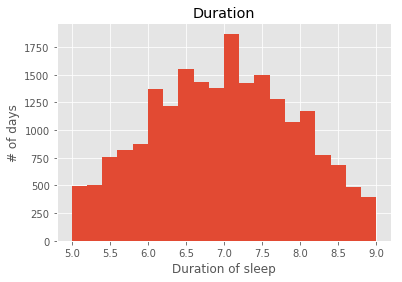

In [12]:
sleep_filtered.hist(bins=20)
plt.xlabel('Duration of sleep')
plt.ylabel('# of days');

In [13]:
sleep_filtered['sleep_time_plot'] = (sleep_filtered['sleep_time'] - sleep_filtered['sleep_time'].dt.normalize()) / pd.Timedelta(hours=1)

sleep_filtered['wakeup_time_plot'] = (sleep_filtered['wakeup_time'] - sleep_filtered['wakeup_time'].dt.normalize()) / pd.Timedelta(hours=1)

In [14]:
mask = sleep_filtered['sleep_time_plot'] >= 21

sleep_filtered.loc[mask, 'sleep_time_plot'] = sleep_filtered[mask]['sleep_time_plot'] - 24

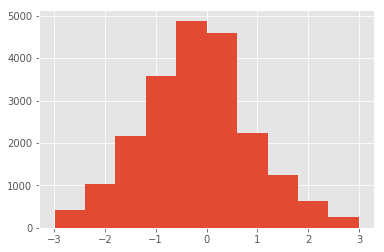

In [16]:
sleep_filtered['sleep_time_plot'].hist()

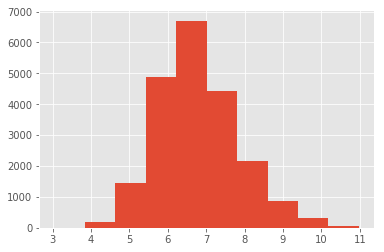

In [17]:
sleep_filtered['wakeup_time_plot'].hist()

In [24]:
sleep_filtered['Day'] = sleep_filtered['wakeup_time'].dt.date
sleep_filtered = sleep_filtered.set_index('Day', append=True)

In [33]:
sleep_filtered.shape

(21066, 5)

In [22]:
wakeup_glucose = wakeup_glucose.reset_index('hour').drop(columns='hour')

wakeup_glucose
RegistrationCode Day                       
111527           2017-11-08      103.071429
                 2017-11-10       98.071429
                 2017-11-11      101.321429
                 2017-11-12      107.071429
                 2017-11-13      106.071429

In [32]:
wakeup_glucose.shape

(25432, 3)

In [34]:
pd.merge(wakeup_glucose, sleep_filtered, on=['RegistrationCode', 'Day'])

,RegistrationCode,Day,wakeup_glucose,sleep_time,wakeup_time,Duration,sleep_time_plot,wakeup_time_plot
0,111527,2017-11-08,103.071429,2017-11-07 22:55:06+02:00,2017-11-08 05:50:40+02:00,6.926111,-1.081667,5.844444
1,111527,2017-11-10,98.071429,2017-11-09 23:15:47+02:00,2017-11-10 06:02:34+02:00,6.779722,-0.736944,6.042778
2,111527,2017-11-11,101.321429,2017-11-11 01:18:50+02:00,2017-11-11 09:12:20+02:00,7.891667,1.313889,9.205556
3,111527,2017-11-12,107.071429,2017-11-11 23:07:37+02:00,2017-11-12 05:30:30+02:00,6.381389,-0.873056,5.508333
4,111527,2017-11-13,106.071429,2017-11-12 23:40:48+02:00,2017-11-13 05:30:43+02:00,5.831944,-0.320000,5.511944
...,...,...,...,...,...,...,...,...
12889,997735,2019-07-04,110.722222,2019-07-04 00:02:54+03:00,2019-07-04 07:00:02+03:00,6.952222,0.048333,7.000556
12890,997735,2019-07-05,92.972222,2019-07-04 23:57:26+03:00,2019-07-05 08:05:01+03:00,8.126389,-0.042778,8.083611
12891,997735,2019-07-06,105.972222,2019-07-06 00:37:11+03:00,2019-07-06 09:34:01+03:00,8.947222,0.619722,9.566944
12892,997735,2019-07-07,101.472222,2019-07-06 23:43:39+03:00,2019-07-07 07:17:01+03:00,7.556111,-0.272500,7.283611


More than a half of the people actually have their sleep time logged, but I will anyway first try to take midnight till 6 am as a sleep time for everyone to generate stats.

### Stats of the night

In [53]:
def add_gluc_adj_pnp3(study_ids=[3,49]):    

    """"""
    # Get the cgm df and combine it with adjusted glucose 
    cgmdf = cgml.get_data(study_ids=study_ids).df
    cgmdf = cgml._remove_first_day_of_connections(cgmdf)
    cgmdf = cgmdf.reset_index()
    cgmdf['hour'] = cgmdf.Date.dt.hour
    cgmdf = cgmdf.set_index('Date')
    cgmdf.index = cgmdf.index.tz_localize(None)
    adj_gluc = pd.read_json('/home/elming/Cache/adj_gl.json')
    adj_gluc['ConnectionID'] = adj_gluc['ConnectionID'].astype(str)
    adj_gluc['GlucoseTimestamp'] = pd.to_datetime(adj_gluc['GlucoseTimestamp'])
    adj_gluc = adj_gluc.rename(columns={'GlucoseTimestamp':'Date'})
    # adj_gluc = adj_gluc.set_index(['ConnectionID', 'Date'])
    cgm_adj = pd.merge(cgmdf, adj_gluc[['GlucoseAdj50N13_Mm', 'Date', 'ConnectionID']], on=['ConnectionID', 'Date'])
    cgm_adj = cgm_adj.rename(columns={'GlucoseAdj50N13_Mm':'GlucoseAdj'})

    return cgm_adj

In [54]:
cgm_adj = add_gluc_adj_pnp3()

In [259]:
def filter_by_time(df, start, end):
    
    """
    The function filters the cgm entries between certain hours of the day. 
    The output is a dataframe containing the entries between start and end hour of each day.
    :param df: CGM DataFrame
    :param start: string of a type 'hh:mm'
    :param end: string of a type 'hh:mm'
    :return: filtered DataFrame with an index set to 'RegistrationCode', 'Day' and 'Time'
    """

    df = df.set_index('Date')
    filtered_df = df.between_time(start, end)
    pd.options.mode.chained_assignment = None  # to avoid the warning message about chained assignments
    filtered_df['Day'] = filtered_df.index.date
    # Make it a separate function
    # From the night cgm adjusted I need to remove nights with less than 20 observations
#     count = filtered_df.groupby(['RegistrationCode', 'Day'])['GlucoseAdj'].count()
#     rc_days_to_keep = count[count >= 20].index
#     filtered_df = filtered_df.set_index(['RegistrationCode', 'Day'])
#     filtered_df = filtered_df.loc[rc_days_to_keep]
    
    return filtered_df

In [142]:
night_cgm_adj = filter_by_time(cgm_adj, '00:00', '06:00')

In [256]:
night_cgm_adj.head()

ConnectionID  GlucoseValue  PPGR  hour  GlucoseAdj
RegistrationCode Day                                                          
111527           2017-11-08         1926         100.0  0.00     0   98.571429
                 2017-11-08         1926          97.0  0.00     0   95.571429
                 2017-11-08         1926          96.0  0.00     0   94.571429
                 2017-11-08         1926          93.0  1.75     0   91.571429
                 2017-11-08         1926          90.0  9.25     1   88.571429

In [100]:
def count_stats(cgm_df):
    
    def q50(x):
        return x.quantile(0.5)

    def q75(x):
        return x.quantile(0.75)

    def q90(x):
        return x.quantile(0.9)

    def q95(x):
        return x.quantile(0.95)

    f = {'GlucoseAdj': ['mean', 'std', q50, q75, q90, q95]}
    
    stats = cgm_df.groupby(['RegistrationCode', 'Day'])['GlucoseAdj'].agg(f)
    stats.columns = stats.columns.droplevel()
    stats['CV'] = stats['std'] / stats['mean']
    return stats

In [168]:
night_cgm_stats = count_stats(night_cgm_adj)

/home/elming/anaconda3/envs/mylabdata/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)



In [169]:
night_cgm_stats.head()

mean        std         q50         q75  \
RegistrationCode Day                                                         
111527           2017-11-08   96.529762   6.188904   95.571429  100.571429   
                 2017-11-09   99.696429   6.641847   99.071429  103.571429   
                 2017-11-10   92.321429   5.350742   93.071429   96.821429   
                 2017-11-11  111.196429  11.293755  109.571429  118.321429   
                 2017-11-12   93.071429   2.570738   93.071429   94.571429   

                                    q90         q95        CV  
RegistrationCode Day                                           
111527           2017-11-08  102.571429  105.121429  0.064114  
                 2017-11-09  108.071429  110.421429  0.066621  
                 2017-11-10   99.271429   99.571429  0.057958  
                 2017-11-11  125.771429  133.521429  0.101566  
                 2017-11-12   95.571429   97.271429  0.027621

In [ ]:
night_cgm_stats = night_cgm_stats.reset_index('Day')
night_cgm_stats['Day'] = pd.to_datetime(night_cgm_stats['Day'])
night_cgm_stats.head()

In [312]:
night_cgm_stats_wakeup = pd.merge(wakeup_glucose, night_cgm_stats, on=['RegistrationCode', 'Day'])

In [322]:
night_cgm_stats_wakeup.head()

,RegistrationCode,Day,wakeup_glucose,mean,std,q50,q75,q90,q95,CV
0,111527,2017-11-08,103.071429,96.529762,6.188904,95.571429,100.571429,102.571429,105.121429,0.064114
1,111527,2017-11-10,98.071429,92.321429,5.350742,93.071429,96.821429,99.271429,99.571429,0.057958
2,111527,2017-11-11,101.321429,111.196429,11.293755,109.571429,118.321429,125.771429,133.521429,0.101566
3,111527,2017-11-12,107.071429,93.071429,2.570738,93.071429,94.571429,95.571429,97.271429,0.027621
4,111527,2017-11-13,106.071429,89.696429,2.542038,89.571429,90.571429,92.571429,93.421429,0.028340


In [315]:
# Transforming all the table into Z-scores
means = night_cgm_stats_wakeup.drop(columns='Day').groupby('RegistrationCode').mean()
std = night_cgm_stats_wakeup.drop(columns='Day').groupby('RegistrationCode').std()
night_cgm_stats_wakeupz = night_cgm_stats_wakeup.set_index('RegistrationCode')

night_cgm_stats_wakeupz = night_cgm_stats_wakeupz.drop(columns='Day')
# standartization of the values into z scores
for rc in night_cgm_stats_wakeupz.index.unique():
    night_cgm_stats_wakeupz.loc[rc] = (night_cgm_stats_wakeupz.loc[rc] - means.loc[rc])/std.loc[rc]

In [323]:
night_cgm_stats_wakeupz.shape

(23672, 8)

In [324]:
night_cgm_stats_wakeup.shape

(23672, 10)

### Correlation between the wakeup glucose and CV of the night

In [209]:
#Z-transformed wakeup glucose and CV
spearman = spearmanr(night_cgm_stats_wakeup['CV'], night_cgm_stats_wakeup['wakeup_glucose'])
print(spearman)

SpearmanrResult(correlation=-0.1172923918251988, pvalue=2.7636586106814287e-73)


In [325]:
#Not transformed CV but transformed wakeup glucose
spearman = spearmanr(night_cgm_stats_wakeup['CV'], night_cgm_stats_wakeupz['wakeup_glucose'])
print(spearman)

SpearmanrResult(correlation=-0.10423996578331701, pvalue=3.46552335223662e-58)


In [193]:
pearson = pearsonr(night_cgm_stats_wakeup['CV'], night_cgm_stats_wakeup['wakeup_glucose'])
print(pearson)

(-0.15788244125999729, 5.901224284518917e-132)


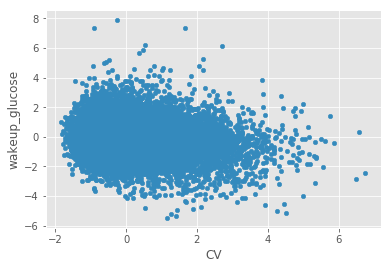

In [195]:
night_cgm_stats_wakeup.plot.scatter(x='CV', y='wakeup_glucose')

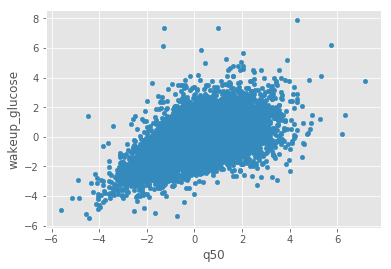

In [210]:
night_cgm_stats_wakeup.plot.scatter(x='q50', y='wakeup_glucose')

Study individual correlations

In [250]:
night_cgm_stats_wakeup.head()

,wakeup_glucose,mean,std,q50,q75,q90,q95,CV
RegistrationCode,,,,,,,,
111527,0.297220,-0.172687,-0.069862,-0.177058,-0.119000,-0.263344,-0.247947,-0.023088
111527,-0.337392,-0.717476,-0.263594,-0.516275,-0.498079,-0.535849,-0.651463,-0.174821
111527,0.075106,1.725981,1.110068,1.722559,1.675304,1.652444,1.816890,0.899994
111527,0.804910,-0.620385,-0.906161,-0.516275,-0.725526,-0.841384,-0.818686,-0.922532
111527,0.677987,-1.057294,-0.912795,-0.991179,-1.129876,-1.089115,-1.098602,-0.904803


I need to create a table with unique registration codes as index and two columns with 0: rho and pvalue

In [213]:
unique_rc_list = night_cgm_stats_wakeup.index.unique()

ind_corr_df = pd.DataFrame(index=unique_rc_list, columns=['rho','pvalue'])

In [218]:
for rc in night_cgm_stats_wakeup.index.unique():
    spearman = spearmanr(night_cgm_stats_wakeup.loc[rc]['wakeup_glucose'], night_cgm_stats_wakeup.loc[rc]['CV'])
    ind_corr_df.loc[rc, 'rho'] = spearman[0]
    ind_corr_df.loc[rc, 'pvalue'] = spearman[1]

In [222]:
pvalues = ind_corr_df['pvalue']
pvalues_corrected = pd.Series(fdrcorrection(pvalues)[1])
pvalues_corrected.index = ind_corr_df.index

In [224]:
ind_corr_df['pvalues_corrected'] = pvalues_corrected

In [227]:
sign_corr = ind_corr_df[ind_corr_df['pvalues_corrected'] < 0.05]

In [229]:
sign_corr.head()

,rho,pvalue,pvalues_corrected
RegistrationCode,,,
12752,-0.325173,0.00470038,0.0270272
136529,-0.303164,0.00084674,0.00834643
148574,-0.259643,0.00615898,0.03269
215130,-0.222153,0.00436999,0.0258454
242185,-0.436184,1.53682e-07,3.18122e-05


In [238]:
sign_corr = sign_corr.reset_index()

In [451]:
sign_corr.shape

(50, 4)

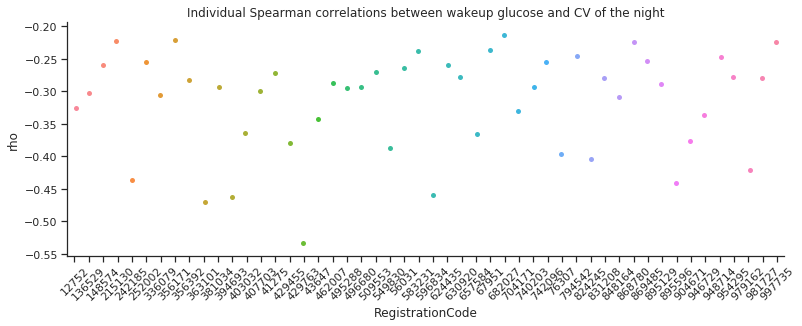

In [249]:
import seaborn as sns
sns.set(style="ticks")
g = sns.catplot(x='RegistrationCode', y="rho", data=sign_corr)
g.fig.set_figheight(4)
g.fig.set_figwidth(14)
g.set_xticklabels(rotation=45)
plt.title('Individual Spearman correlations between wakeup glucose and CV of the night')
plt.show()

Let's see how does the scatterplot look for the person with the highest negative correlation

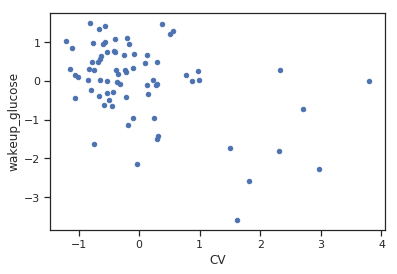

In [284]:
night_cgm_stats_wakeup.loc['12752'].plot.scatter(x='CV', y='wakeup_glucose')

Do correlations between CV and the diet day before

## CV of the night split into 0-3 am and 3-6 am

In [260]:
night_cgm_1 = filter_by_time(cgm_adj, '00:00', '03:00')
night_cgm_2 = filter_by_time(cgm_adj, '03:00', '06:00')

In [261]:
night_cgm_1.head()

,RegistrationCode,ConnectionID,GlucoseValue,PPGR,hour,GlucoseAdj,Day
Date,,,,,,,
2017-11-08 00:12:00,111527,1926,100.0,0.00,0,98.571429,2017-11-08
2017-11-08 00:27:00,111527,1926,97.0,0.00,0,95.571429,2017-11-08
2017-11-08 00:42:00,111527,1926,96.0,0.00,0,94.571429,2017-11-08
2017-11-08 00:57:00,111527,1926,93.0,1.75,0,91.571429,2017-11-08
2017-11-08 01:12:00,111527,1926,90.0,9.25,1,88.571429,2017-11-08


In [266]:
def check_for_complete_data(df):
    """Leaves only those RCs and days where there is complete cgm data for desired period"""
    
    count = df.groupby(['RegistrationCode', 'Day'])['GlucoseAdj'].count()
    rc_days_to_keep = count[count >= 12].index
    df = df.set_index(['RegistrationCode', 'Day'])
    df = df.loc[rc_days_to_keep]
    return df

In [268]:
night_cgm_1 = check_for_complete_data(night_cgm_1)
night_cgm_2 = check_for_complete_data(night_cgm_2)

In [269]:
night_stats_1 = count_stats(night_cgm_1)
night_stats_2 = count_stats(night_cgm_2)

/home/elming/anaconda3/envs/mylabdata/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)



In [270]:
night_stats_1.head()

mean        std         q50         q75  \
RegistrationCode Day                                                         
111527           2017-11-08   93.321429   4.223850   94.071429   96.071429   
                 2017-11-09  102.321429   7.098335  102.571429  105.821429   
                 2017-11-10   90.404762   4.152400   90.071429   93.821429   
                 2017-11-11  118.988095  10.672465  119.071429  123.071429   
                 2017-11-12   92.071429   2.576114   91.571429   92.821429   

                                    q90         q95        CV  
RegistrationCode Day                                           
111527           2017-11-08   98.471429   98.571429  0.045261  
                 2017-11-09  110.471429  112.371429  0.069373  
                 2017-11-10   94.571429   95.921429  0.045931  
                 2017-11-11  133.871429  135.471429  0.089694  
                 2017-11-12   95.371429   96.471429  0.027980

In [271]:
night_stats_1 = night_stats_1.reset_index('Day')
night_stats_1['Day'] = pd.to_datetime(night_stats_1['Day'])
night_stats_1_wakeup = pd.merge(wakeup_glucose, night_stats_1, on=['RegistrationCode', 'Day'])

In [272]:
night_stats_2 = night_stats_2.reset_index('Day')
night_stats_2['Day'] = pd.to_datetime(night_stats_2['Day'])
night_stats_2_wakeup = pd.merge(wakeup_glucose, night_stats_2, on=['RegistrationCode', 'Day'])

In [273]:
night_stats_1_wakeup.head()

,RegistrationCode,Day,wakeup_glucose,mean,std,q50,q75,q90,q95,CV
0,111527,2017-11-08,103.071429,93.321429,4.223850,94.071429,96.071429,98.471429,98.571429,0.045261
1,111527,2017-11-10,98.071429,90.404762,4.152400,90.071429,93.821429,94.571429,95.921429,0.045931
2,111527,2017-11-11,101.321429,118.988095,10.672465,119.071429,123.071429,133.871429,135.471429,0.089694
3,111527,2017-11-12,107.071429,92.071429,2.576114,91.571429,92.821429,95.371429,96.471429,0.027980
4,111527,2017-11-13,106.071429,88.404762,0.834847,88.571429,88.821429,89.571429,89.571429,0.009443


In [274]:
def standardize_df(df):
    '''Turn numerical values to Z-scores'''
    # Transforming all the table into Z-scores
    means = df.drop(columns='Day').groupby('RegistrationCode').mean()
    std = df.drop(columns='Day').groupby('RegistrationCode').std()
    df = df.set_index('RegistrationCode')

    df = df.drop(columns='Day')
    # standartization of the values into z scores
    for rc in df.index.unique():
        df.loc[rc] = (df.loc[rc] - means.loc[rc])/std.loc[rc]
    return df

In [277]:
night_stats_1_wakeup = standardize_df(night_stats_1_wakeup)
night_stats_2_wakeup = standardize_df(night_stats_2_wakeup)

In [278]:
spearman = spearmanr(night_stats_1_wakeup['CV'], night_stats_1_wakeup['wakeup_glucose'])
print(spearman)

SpearmanrResult(correlation=-0.09644704371715299, pvalue=6.917380887365568e-45)


In [279]:
spearman = spearmanr(night_stats_2_wakeup['CV'], night_stats_2_wakeup['wakeup_glucose'])
print(spearman)

SpearmanrResult(correlation=-0.04428602302841213, pvalue=6.2901844517916465e-12)


In [280]:
pearson = pearsonr(night_stats_1_wakeup['CV'], night_stats_1_wakeup['wakeup_glucose'])
print(pearson)

(-0.11976540818600545, 2.0848586648101754e-68)


In [281]:
pearson = pearsonr(night_stats_2_wakeup['CV'], night_stats_2_wakeup['wakeup_glucose'])
print(pearson)

(-0.08362098187264952, 1.3257621922369289e-38)


## Relation between wakeup glucose and CV of the day before (7 am to midnight) and evening only (6 pm to midnight)

In [293]:
day_cgm_total = filter_by_time(cgm_adj, '07:00', '23:59')
evening_cgm = filter_by_time(cgm_adj, '18:00', '23:59')

In [294]:
evening_cgm.sample(5)

,RegistrationCode,ConnectionID,GlucoseValue,PPGR,hour,GlucoseAdj,Day
Date,,,,,,,
2019-02-03 20:11:00,590916,4875,131.0,28.750,20,138.818182,2019-02-03
2019-11-07 19:55:00,868780,6081,91.0,0.000,19,89.000000,2019-11-07
2019-06-02 19:51:00,246043,5681,83.0,3.875,19,76.125000,2019-06-02
2018-04-08 18:59:00,631485,2857,91.0,25.125,18,92.333333,2018-04-08
2018-02-25 21:55:00,225207,2484,111.0,20.000,21,105.375000,2018-02-25


In [295]:
def check_for_complete_data(df, numb_ts=1):
    """Leaves only those RCs and days where there is complete cgm data for desired period"""
    
    count = df.groupby(['RegistrationCode', 'Day'])['GlucoseAdj'].count()
    rc_days_to_keep = count[count >= numb_ts].index
    df = df.set_index(['RegistrationCode', 'Day'])
    df = df.loc[rc_days_to_keep]
    return df

In [296]:
day_cgm_total = check_for_complete_data(day_cgm_total, numb_ts=64)
evening_cgm = check_for_complete_data(evening_cgm, numb_ts=20)

In [297]:
day_cgm_stats = count_stats(day_cgm_total )
evening_stats = count_stats(evening_cgm)

/home/elming/anaconda3/envs/mylabdata/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)



In [298]:
day_cgm_stats.head()

mean        std         q50         q75  \
RegistrationCode Day                                                         
111527           2017-11-08  116.527311  20.315007  113.571429  128.571429   
                 2017-11-09  112.347548  25.847936  103.571429  119.571429   
                 2017-11-10  114.424370  23.704817  112.071429  123.571429   
                 2017-11-11  111.889610  14.878130  109.071429  117.571429   
                 2017-11-12  112.439076  27.327699  104.071429  130.571429   

                                    q90         q95        CV  
RegistrationCode Day                                           
111527           2017-11-08  146.571429  153.171429  0.174337  
                 2017-11-09  133.971429  174.571429  0.230071  
                 2017-11-10  141.371429  163.871429  0.207166  
                 2017-11-11  130.071429  142.821429  0.132972  
                 2017-11-12  151.371429  159.171429  0.243044

In [299]:
day_cgm_stats = day_cgm_stats.reset_index('Day')
day_cgm_stats['Day'] = pd.to_datetime(day_cgm_stats['Day'])
day_cgm_stats['Day'] = day_cgm_stats['Day'] + datetime.timedelta(days=1)
day_cgm_stats_wakeup = pd.merge(wakeup_glucose, day_cgm_stats, on=['RegistrationCode', 'Day'])

In [300]:
evening_stats = evening_stats.reset_index('Day')
evening_stats['Day'] = pd.to_datetime(evening_stats['Day'])
evening_stats['Day'] = evening_stats['Day'] + datetime.timedelta(days=1)
evening_stats_wakeup = pd.merge(wakeup_glucose, evening_stats, on=['RegistrationCode', 'Day'])

In [304]:
day_cgm_stats_wakeup.head()

,wakeup_glucose,mean,std,q50,q75,q90,q95,CV
RegistrationCode,,,,,,,,
111527,-0.290612,0.799383,2.405655,-0.298565,0.510549,0.410040,2.653169,2.436699
111527,0.112428,1.214772,1.909071,1.546036,1.117485,1.121992,1.864808,1.802793
111527,0.825499,0.707790,-0.136166,0.895000,0.207081,0.034822,0.313874,-0.250531
111527,0.701486,0.817689,2.748531,-0.190060,2.179624,2.084090,1.518519,2.795734
111527,0.174434,0.614736,1.766133,0.460976,1.686488,1.237444,0.829624,1.803939


In [274]:
def standardize_df(df):
    '''Turn numerical values to Z-scores'''
    # Transforming all the table into Z-scores
    means = df.drop(columns='Day').groupby('RegistrationCode').mean()
    std = df.drop(columns='Day').groupby('RegistrationCode').std()
    df = df.set_index('RegistrationCode')

    df = df.drop(columns='Day')
    # standartization of the values into z scores
    for rc in df.index.unique():
        df.loc[rc] = (df.loc[rc] - means.loc[rc])/std.loc[rc]
    return df

In [302]:
day_cgm_stats_wakeup = standardize_df(day_cgm_stats_wakeup)

KeyError: "None of ['RegistrationCode'] are in the columns"

In [303]:
evening_stats_wakeup = standardize_df(evening_stats_wakeup)

In [307]:
spearman = spearmanr(day_cgm_stats_wakeup['CV'], day_cgm_stats_wakeup['wakeup_glucose'])
print(spearman)

SpearmanrResult(correlation=-0.03890395468201828, pvalue=3.5106303497549454e-06)


In [306]:
spearman = spearmanr(evening_stats_wakeup['CV'], evening_stats_wakeup['wakeup_glucose'])
print(spearman)

SpearmanrResult(correlation=-0.051072120917598586, pvalue=9.683276347762358e-13)


## CGM plot study on an example

I want to understand how is it possible that the wakeup glucose is negatively correlated with the CV of the night. For that let's take a person that has high correlation and plot his daily CGMs: one with low CV and another one with high CV

In [1078]:
night_cgm_stats_wakeup[(night_cgm_stats_wakeup['CV'] > 0.2) & (night_cgm_stats_wakeup['RegistrationCode'] == '429763')]

,RegistrationCode,Day,wakeup_glucose,mean,std,q50,q75,q90,q95,CV
8838,429763,2018-11-04,112.613636,122.238636,28.166141,122.363636,143.863636,163.863636,166.213636,0.230419
8840,429763,2018-11-10,65.613636,83.363636,21.350084,78.863636,104.363636,112.063636,114.913636,0.256108
8845,429763,2018-11-23,81.431818,90.056818,18.188177,97.181818,104.431818,107.181818,108.881818,0.201963
8846,429763,2018-11-24,67.181818,104.265152,23.248968,108.181818,116.181818,131.581818,144.081818,0.222979
8847,429763,2018-11-28,98.000000,155.875000,44.558035,156.500000,195.000000,212.700000,218.100000,0.285857
8851,429763,2018-12-04,99.500000,121.125000,26.813871,126.500000,145.000000,153.700000,161.650000,0.221374
8852,429763,2018-12-08,44.666667,73.791667,28.063560,57.500000,100.750000,117.300000,120.850000,0.380308
8867,429763,2019-02-13,103.000000,147.916667,33.894551,157.250000,174.750000,189.050000,192.800000,0.229146
8873,429763,2019-03-01,109.333333,144.521739,33.222213,134.000000,175.000000,192.800000,196.700000,0.229877


In [466]:
night_cgm_stats_wakeup[(night_cgm_stats_wakeup['CV'] < 0.1) & (night_cgm_stats_wakeup['RegistrationCode'] == '407703')]

,RegistrationCode,Day,wakeup_glucose,mean,std,q50,q75,q90,q95,CV
8315,407703,2018-10-15,92.500000,73.416667,5.182887,74.000000,76.500000,79.400000,80.850000,0.070596
8316,407703,2018-10-16,86.250000,94.083333,9.188446,92.000000,97.250000,105.900000,113.100000,0.097663
8317,407703,2018-10-17,94.500000,98.458333,5.291331,97.500000,101.750000,105.700000,106.850000,0.053742
8318,407703,2018-10-18,89.750000,96.750000,7.847736,94.000000,106.000000,107.000000,107.000000,0.081114
8319,407703,2018-10-22,88.250000,84.250000,4.589686,85.000000,86.500000,89.700000,90.850000,0.054477
...,...,...,...,...,...,...,...,...,...,...
8451,407703,2019-04-25,89.250000,85.541667,4.596588,85.000000,87.500000,91.400000,92.000000,0.053735
8452,407703,2019-04-26,90.000000,93.291667,2.595635,93.000000,95.000000,96.000000,96.850000,0.027823
8453,407703,2019-04-27,86.750000,90.208333,4.383558,90.000000,93.250000,95.000000,95.850000,0.048594
8455,407703,2019-11-02,83.535714,90.452381,8.765876,88.285714,92.035714,105.385714,107.985714,0.096911


In [453]:
sign_corr[sign_corr['RegistrationCode'] == '407703']

,RegistrationCode,rho,pvalue,pvalues_corrected
13,407703,-0.299033,0.000285726,0.00422467


In [341]:
def vis_cgm(rc, date):
    import plotly.express as px
    cgm_slice = cgm_adj[(cgm_adj['RegistrationCode'] == rc) & (cgm_adj['Date'].dt.date == date)]
    return px.line(cgm_slice, x="Date", y="GlucoseAdj", title='day CGM')

In [1081]:
vis_cgm('429763', datetime.date(2018,11,4))

Now it would be interesting to see the log information of this person and his sleep and wakeup time if available.

In [354]:
log = dll.get_data(study_ids=[3,49]).df
logdf = dll.add_nutrients(log, nutrient_list)
logdf = dll.squeeze_log(logdf)
logdf = logdf.reset_index()

In [1083]:
logdf[(logdf['RegistrationCode'] == '429763') & (logdf['Date'].dt.date == datetime.date(2018,11,3))]

,RegistrationCode,Day,Date,caffeine_mg,weight,totaldietaryfiber_g,sodium_mg,totallipid_g,energy_kcal,protein_g,carbohydrate_g,sugarstotal_g,meal_type,alloc
92305,429763,2018-11-03,2018-11-03 07:15:22+02:00,108.0,270.0,0.000000,48.60000,1.332000,21.90000,1.158000,1.380000,0.00000,Beverage,0
92306,429763,2018-11-03,2018-11-03 08:24:56+02:00,108.0,290.0,0.000000,58.60000,1.932000,33.30000,1.738000,2.300000,0.00000,Beverage,0
92307,429763,2018-11-03,2018-11-03 10:06:48+02:00,0.0,182.5,7.396500,1059.41400,25.181350,389.68000,20.728850,18.947950,1.46755,Meal,0
92308,429763,2018-11-03,2018-11-03 12:52:11+02:00,31.2,296.5,2.219274,78.67596,21.672648,281.99840,5.840583,17.201288,0.71775,Snack,0
92309,429763,2018-11-03,2018-11-03 16:01:41+02:00,0.0,397.0,3.313940,1175.52195,27.646579,568.67853,59.643783,15.425541,1.64500,Meal,0
92310,429763,2018-11-03,2018-11-03 18:06:27+02:00,0.0,32.5,1.345500,66.41000,11.559650,154.34200,3.520950,9.956650,0.43065,Snack,0
92311,429763,2018-11-03,2018-11-03 22:29:07+02:00,0.0,200.0,0.054000,806.43400,21.946000,359.80000,17.156000,23.417000,0.00000,Meal,1


In [363]:
sleep_filtered = sleep_filtered.reset_index()
sleep_filtered[(sleep_filtered['RegistrationCode'] == '363101') & (sleep_filtered['wakeup_time'].dt.date == datetime.date(2019,4,7))]

,level_0,index,RegistrationCode,Day,sleep_time,wakeup_time,Duration,sleep_time_plot,wakeup_time_plot
7414,7414,7414,363101,2019-04-07,2019-04-07 00:47:53+03:00,2019-04-07 07:32:44+03:00,6.7475,0.798056,7.545556


In [369]:
# CV of 0.04
vis_cgm('363101', datetime.date(2019,3,14))

In [375]:
logdf[(logdf['RegistrationCode'] == '363101') & (logdf['Date'].dt.date == datetime.date(2019,3,14))]

,RegistrationCode,Date,caffeine_mg,weight,totaldietaryfiber_g,sodium_mg,totallipid_g,energy_kcal,protein_g,carbohydrate_g,sugarstotal_g,meal_type
77803,363101,2019-03-14 08:00:26+02:00,0.0,52.000000,2.453000,28.500000,4.123000,106.020000,2.869500,13.967000,0.31070,Snack
77804,363101,2019-03-14 09:39:51+02:00,0.0,126.400002,6.393600,764.334729,10.035520,329.552004,15.702400,44.057601,0.00000,Meal
77805,363101,2019-03-14 13:36:08+02:00,0.0,20.000000,0.840000,62.000000,2.600000,70.200000,1.200000,13.000000,0.00000,Snack
77806,363101,2019-03-14 14:25:19+02:00,0.0,678.000000,24.885085,3044.894460,7.414971,697.161240,78.163839,55.240056,0.27000,Meal
77807,363101,2019-03-14 16:57:30+02:00,0.0,184.000000,5.704000,1.840000,0.220800,106.720000,0.699200,22.742400,18.03200,Snack
77808,363101,2019-03-14 19:20:58+02:00,0.0,65.000000,2.455000,34.810000,1.544400,124.620000,2.759300,22.912400,5.22230,Snack
77809,363101,2019-03-14 21:10:47+02:00,0.0,297.000000,4.142275,595.399000,16.298555,366.402650,26.734617,25.268225,1.67790,Meal
77810,363101,2019-03-14 21:45:41+02:00,0.0,18.000000,0.990000,1.980000,4.140000,69.660000,1.800000,6.300000,0.04878,Meal


In [374]:
sleep_filtered[(sleep_filtered['RegistrationCode'] == '363101') & (sleep_filtered['wakeup_time'].dt.date == datetime.date(2019,3,14))]

,level_0,index,RegistrationCode,Day,sleep_time,wakeup_time,Duration,sleep_time_plot,wakeup_time_plot


In [379]:
# CV of 0.04
vis_cgm('363101', datetime.date(2019,5,13))

In [380]:
logdf[(logdf['RegistrationCode'] == '363101') & (logdf['Date'].dt.date == datetime.date(2019,5,13))]

,RegistrationCode,Date,caffeine_mg,weight,totaldietaryfiber_g,sodium_mg,totallipid_g,energy_kcal,protein_g,carbohydrate_g,sugarstotal_g,meal_type
78127,363101,2019-05-13 08:59:58+03:00,0.00,111.0,5.922535,337.421,3.123424,154.825818,11.87286,18.64305,0.547760,Meal
78128,363101,2019-05-13 12:00:35+03:00,0.00,250.0,0.000000,8.400,0.225000,144.000000,2.07500,33.67500,0.000000,Meal
78129,363101,2019-05-13 14:08:03+03:00,3.55,309.5,0.957000,502.850,14.842450,535.910000,48.57140,46.52210,2.457000,Meal
78130,363101,2019-05-13 17:20:55+03:00,0.00,77.0,2.925000,67.750,7.286000,172.880000,4.74050,23.27600,0.231500,Snack
78131,363101,2019-05-13 21:05:14+03:00,0.00,309.0,5.119000,335.320,16.602800,310.440000,14.41710,26.27010,3.728100,Meal
78132,363101,2019-05-13 22:15:00+03:00,31.20,276.0,0.546480,42.900,6.300000,166.380000,1.98000,25.32000,13.807404,Snack


## Binary data about snacks in the evening

Hypothesis: snacks after 22 are positively associated with night CV and negatively with wakeup glucose the next day.
I need to experimentally look for the min amount of calories for the night snack that is mostly correlated with wg and cv. 
Multiple categories for the snack variable could look like this for example:
- snack > 30 kcal - yes/no 
- snack > 30 kcal > 80% carbs
- snack > 30 kcal 50-80% carbs
- snack > 30 kcal < 50% carbs
- snack > 30 kcal > 50% fat

In [383]:
from scipy.stats import pointbiserialr

In [951]:
def night_snacks_binary(nutrient_list=['energy_kcal', 'totallipid_g', 'carbohydrate_g'], 
                        study_ids=[3,49], min_cal_per_day=1000, snack_time=datetime.time(22, 0, 0), snack_min_cal = 100):
   
    """Calculates a table with binary column on late snacks."""
    
    carbs_cal_per_gram = 4
    fat_cal_per_gram = 9
    prot_cal_per_gram = 4
    
    log = dll.get_data(study_ids=study_ids).df
    logdf = dll.add_nutrients(log, nutrient_list)
    logdf = dll.squeeze_log(logdf)
    logdf = logdf.reset_index()
    logdf['Day'] = logdf['Date'].dt.date
    # Identify days with good log more than min_cal_per_day
    totaldaylog = logdf.drop(columns=['meal_type']).groupby(['RegistrationCode', 'Day']).sum()
    totaldaylog = totaldaylog[totaldaylog['energy_kcal'] >= min_cal_per_day]
    days_to_keep = totaldaylog.index
    logdf = logdf.set_index(['RegistrationCode', 'Day'])
    logdf = logdf.loc[days_to_keep]
    # Allocate data to late snack and the rest
    logdf['alloc'] = 0
    logdf.loc[(logdf['Date'].dt.time >= snack_time), 'alloc'] = 1
    # Sum nutrient values for both periods
    logdf = logdf.reset_index()
    snack_binary = logdf.groupby(['RegistrationCode', 'Day', 'alloc']).sum()
    # Drop default column 'weight'
    snack_binary = snack_binary.drop(columns=['weight'])
    # Calculate percentages of carbs and lipids from the total diet
    snack_binary['caloric%carbs'] = snack_binary['carbohydrate_g'] * 4 / snack_binary['energy_kcal']
    snack_binary['caloric%fat'] = snack_binary['totallipid_g'] * 9 / snack_binary['energy_kcal']
    snack_binary = snack_binary.drop(columns=['carbohydrate_g', 'totallipid_g'])
    snack_binary = snack_binary.unstack(level=-1)
    # Remove columns with diet data before snack_time
    for column in snack_binary.columns:
        if column[1] == 0:
            snack_binary = snack_binary.drop(columns=column)
    snack_binary = snack_binary.fillna(0)
    # Get rid of the columns multiindex
    snack_binary.columns = ['energy_kcal', 'caloric%carbs', 'caloric%fat']
    snack_binary.columns.name = None
    # Create binary snack categories
    snack_binary['snack'] = 0
    snack_binary.loc[(snack_binary['energy_kcal'] > snack_min_cal), 'snack'] = 1

    snack_binary['carbs%>fat%'] = 0
    snack_binary.loc[(snack_binary['energy_kcal'] > snack_min_cal) & (snack_binary['caloric%carbs'] > snack_binary['caloric%fat']), 
                                 'carbs%>fat%'] = 1
    
    snack_binary['fat%>carbs%'] = 0
    snack_binary.loc[(snack_binary['energy_kcal'] > snack_min_cal) & (snack_binary['caloric%carbs'] < snack_binary['caloric%fat']), 
                                 'fat%>carbs%'] = 1
    
    snack_binary['carbs<20%'] = 0
    snack_binary.loc[(snack_binary['energy_kcal'] > snack_min_cal) & (snack_binary['caloric%carbs'] <= 0.2), 'carbs<20%'] = 1
    snack_binary['carbs>20%'] = 0
    snack_binary.loc[(snack_binary['energy_kcal'] > snack_min_cal) & (snack_binary['caloric%carbs'] >= 0.2), 'carbs>20%'] = 1
    
    snack_binary['fat>50%'] = 0
    snack_binary.loc[(snack_binary['energy_kcal'] > snack_min_cal) & (snack_binary['caloric%fat'] >= 0.5), 'fat>50%'] = 1
    
    # Add 1 day to snacks date in order to merge it correctly with wg and cv
    snack_binary = snack_binary.reset_index('Day')
    snack_binary['Day'] = snack_binary['Day'] + datetime.timedelta(days=1)
    
    return snack_binary

In [820]:
def merge_cv_wg_snacks(night_stats, wg, snacks):
    """Creates one table with cv and wg z-transformed"""
    cv_wakeup = pd.merge(wg, night_stats[['RegistrationCode','Day','CV']], on = ['RegistrationCode', 'Day'])
    # Transforming all the table into Z-scores
    means = cv_wakeup.drop(columns='Day').groupby('RegistrationCode').mean()
    std = cv_wakeup.drop(columns='Day').groupby('RegistrationCode').std()
    cv_wakeupz = cv_wakeup.set_index('RegistrationCode')
    # standartization of the values into z scores
    for rc in cv_wakeupz.index.unique():
        cv_wakeupz.loc[rc, ('wakeup_glucose', 'CV')] = (cv_wakeupz.loc[rc, ('wakeup_glucose', 'CV')] - 
                                                                                        means.loc[rc])/std.loc[rc]
    cv_wakeup_snacks = pd.merge(snacks, cv_wakeupz, on=['RegistrationCode', 'Day'])
    
    return cv_wakeup_snacks

15323 rc days from 43613 with snacks after 22 - good

In [952]:
snack_binary = night_snacks_binary(snack_min_cal=100)

In [953]:
cv_wakeup_snacks = merge_cv_wg_snacks(night_cgm_stats, wakeup_glucose, snack_binary)

In [900]:
cv_wakeup_snacks.shape

(21223, 11)

In [901]:
cv_wakeup_snacks[cv_wakeup_snacks['snack'] == 1].shape

(6035, 11)

In [902]:
cv_wakeup_snacks.index.nunique()

207

Choose a cohort with percentage of the days with snacks more than 20% of the total days

In [863]:
days_count = cv_wakeup_snacks.reset_index().groupby('RegistrationCode').count()['Day'].rename('totaldays')

In [864]:
dayswithsnack = cv_wakeup_snacks.reset_index().groupby('RegistrationCode')['snack'].sum().rename('dayswithsnack')

In [866]:
count_df = pd.merge(days_count, dayswithsnack, on='RegistrationCode')
count_df['%snackdays'] = count_df['dayswithsnack'] / count_df['totaldays']

,totaldays,dayswithsnack,%snackdays
RegistrationCode,,,
111527,121,7,0.057851
126092,131,16,0.122137
12752,73,29,0.397260
130279,126,58,0.460317
132095,139,15,0.107914


In [950]:
count_df[count_df['%snackdays'] > 0.4]

,totaldays,dayswithsnack,%snackdays
RegistrationCode,,,
130279,126,58,0.460317
133828,56,38,0.678571
139531,121,52,0.429752
140050,52,32,0.615385
148574,83,38,0.457831
158748,105,51,0.485714
17298,97,41,0.422680
203977,69,28,0.405797
292372,159,83,0.522013


In [910]:
rcstokeep = count_df[(count_df['totaldays'] >= 60) & (count_df['%snackdays'] >= 0.2)].index

In [911]:
len(rcstokeep)

115

I am keeping 120 rcs in total

In [954]:
cv_wakeup_snacks = cv_wakeup_snacks.loc[rcstokeep]

 ## Correlations between snacks, CV of the night and wakeup glucose

In [933]:
# pbc of total cohort
pbc = pointbiserialr(cv_wakeup_snacks['CV'], cv_wakeup_snacks['snack'])
print(pbc)

PointbiserialrResult(correlation=0.18389362888538824, pvalue=4.6015823236600955e-96)


In [934]:
pbc = pointbiserialr(cv_wakeup_snacks['wakeup_glucose'], cv_wakeup_snacks['snack'])
print(pbc)

PointbiserialrResult(correlation=-0.026905533972706043, pvalue=0.002549638197100251)


Create a convenient table with total cohort correlations

In [935]:
cv_wakeup_snacks.columns

Index(['Day', 'energy_kcal', 'caloric%carbs', 'caloric%fat', 'snack',
       'carbs%>fat%', 'fat%>carbs%', 'carbs<20%', 'fat>50%', 'wakeup_glucose',
       'CV'],
      dtype='object')

In [955]:
rows=['CV', 'wakeup_glucose']
columns=['snack', 'carbs%>fat%', 'fat%>carbs%', 'carbs<20%', 'carbs>20%', 'fat>50%']
totalcohort_corr = pd.DataFrame(index=rows, columns=columns)
totalcohort_pvalue = pd.DataFrame(index=rows, columns=columns)
for row in rows:
    for column_name in columns:
        pbc = pointbiserialr(cv_wakeup_snacks[row], cv_wakeup_snacks[column_name])
        totalcohort_corr.loc[row, column_name] = pbc[0]
        totalcohort_pvalue.loc[row, column_name] = pbc[1]

In [956]:
totalcohort_corr

,snack,carbs%>fat%,fat%>carbs%,carbs<20%,carbs>20%,fat>50%
CV,0.183894,0.15785,0.0850087,-0.034471,0.218485,0.055078
wakeup_glucose,-0.0269055,-0.00846464,-0.0229968,-0.0253926,-0.0127542,-0.0241712


In [957]:
totalcohort_pvalue

,snack,carbs%>fat%,fat%>carbs%,carbs<20%,carbs>20%,fat>50%
CV,4.60158e-96,5.80579e-71,1.30864e-21,0.000110505,9.35139e-136,6.39248e-10
wakeup_glucose,0.00254964,0.342553,0.00991136,0.00440413,0.152674,0.0067152


In [879]:
spearmanr(cv_wakeup_snacks['wakeup_glucose'],cv_wakeup_snacks['CV'])

SpearmanrResult(correlation=-0.13925371914871248, pvalue=1.1180664361572595e-56)

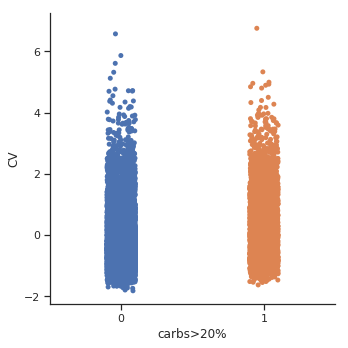

In [958]:
sns.catplot(x="carbs>20%", y="CV", data=cv_wakeup_snacks)

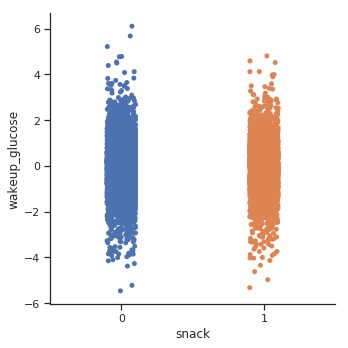

In [944]:
sns.catplot(x="snack", y="wakeup_glucose", data=cv_wakeup_snacks)# , height=8)

In [ ]:
24153, 372475, 954766

Text(0.5,1,'RC=704171')

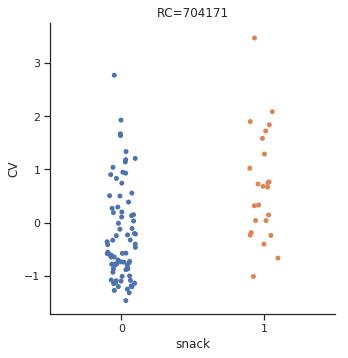

In [983]:
sns.catplot(x="snack", y="CV", data=cv_wakeup_snacks.loc['704171'])
plt.title('RC=704171')

Text(0.5,1,'RC=704171')

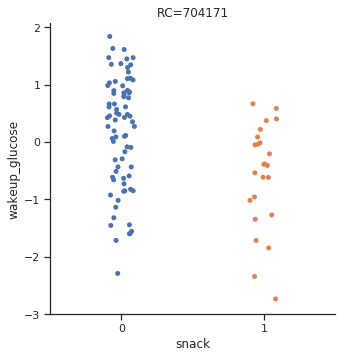

In [981]:
sns.catplot(x="snack", y="wakeup_glucose", data=cv_wakeup_snacks.loc['704171'])
plt.title('RC=704171')

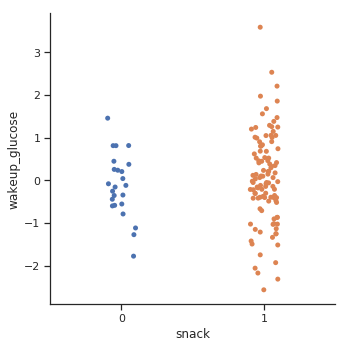

In [979]:
sns.catplot(x="snack", y="wakeup_glucose", data=cv_wakeup_snacks.loc['753413'])

In [686]:
night_cgm_stats = night_cgm_stats.reset_index()

In [728]:
night_cgm_stats.loc[(night_cgm_stats['RegistrationCode'] == '309076') &
                   (night_cgm_stats['CV'] > 0.3)]

,RegistrationCode,Day,mean,std,q50,q75,q90,q95,CV
6900,309076,2017-09-05,108.10119,50.804381,81.642857,112.392857,199.242857,205.242857,0.469971


In [730]:
vis_cgm('309076', datetime.date(2017,9,5))

In [926]:
logdf[(logdf['RegistrationCode'] == '309076') & (logdf['Date'].dt.date == datetime.date(2017,9,5))]
# logdf[(logdf['RegistrationCode'] == '309076')]

,RegistrationCode,Day,Date,caffeine_mg,weight,totaldietaryfiber_g,sodium_mg,totallipid_g,energy_kcal,protein_g,carbohydrate_g,sugarstotal_g,meal_type,alloc


In [968]:
def individual_corr(data_df, between1='CV', between2='carbs>20%'):
    index = data_df.index.unique()
    columns = [between2, 'pvalue']
    indiv_corr_df = pd.DataFrame(index=index, columns=columns)

    # pbc for individuals:
    for rc in data_df.index.unique():
        cv = data_df.loc[rc, between1]
        snacks = data_df.loc[rc, between2]
        pbc = pointbiserialr(cv, snacks)
        indiv_corr_df.loc[rc, between2] = pbc[0]
        indiv_corr_df.loc[rc,'pvalue'] = pbc[1]
        
    return indiv_corr_df

In [976]:
indiv_corr_cv_snack = individual_corr(cv_wakeup_snacks, between1='CV', between2='carbs>20%')
indiv_corr_wg_snack = individual_corr(cv_wakeup_snacks, between1='wakeup_glucose', between2='carbs>20%')

In [977]:
indiv_corr_wg_snack[indiv_corr_wg_snack['pvalue'] < 0.05]

,carbs>20%,pvalue
RegistrationCode,,
216303,0.299741,0.0144819
287239,-0.179418,0.0359186
358113,0.229293,0.0198167
406329,0.200006,0.0247412
605764,-0.191182,0.0175428
704171,-0.331335,0.000712916
753413,0.237161,0.00618082


In [972]:
sign_cvsnack = indiv_corr_cv_snack[indiv_corr_cv_snack['pvalue'] < 0.01].index
sign_wgsnack = indiv_corr_wg_snack[indiv_corr_wg_snack['pvalue'] < 0.05].index 

,carbs>20%,pvalue
RegistrationCode,,
12752,0.327855,0.00463207
228851,0.42784,4.29359e-06
24153,0.57053,6.98533e-07
287239,0.300251,0.000364197
292738,0.280754,0.00057222
302974,0.417315,5.19893e-06
339142,0.241229,0.0094013
376789,0.254169,0.00235531
381094,0.264945,0.00438897


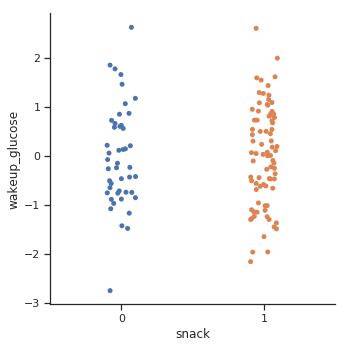

In [1014]:
sns.catplot(x="snack", y="wakeup_glucose", data=cv_wakeup_snacks.loc['868780'])

## Correlations between the food during the day and CV of the night